## Partie 2 : Définition et prédiction des sécheresses extrêmes à partir du SWI uniforme

Identifier les périodes et zones de sécheresse extrême à l’aide de différentes définitions statistiques.

1. Calcul des Seuils Statistiques (Quantile 25%)

In [10]:
import pandas as pd
import geopandas as gpd

gdf_final = gpd.read_parquet("gdf_final.parquet")

In [13]:
import pandas as pd

# 1. On définit les trimestres (ex: Q2 = Avril, Mai, Juin)
# Assurez-vous d'avoir une colonne 'TRIMESTRE' ou créez-la
gdf_final['TRIMESTRE'] = gdf_final['DATE_quot'].dt.quarter

# 2. Calcul du 25ème percentile par commune et par trimestre
# Cela crée une référence historique propre à chaque lieu
thresholds = gdf_final.groupby(['code_insee_de_la_region', 'TRIMESTRE'])['SWI_UNIF_MENS'].quantile(0.25).reset_index()
thresholds.rename(columns={'SWI_UNIF_MENS': 'SEUIL_Q25'}, inplace=True)

# 3. Fusion de ces seuils avec la base principale
df_model = gdf_final.merge(thresholds, on=['code_insee_de_la_region', 'TRIMESTRE'])

# 4. Création de la variable cible binaire (Label)
# 1 = Sécheresse Extrême (SWI < Seuil), 0 = Normal
df_model['IS_EXTREME_DROUGHT'] = (df_model['SWI_UNIF_MENS'] < df_model['SEUIL_Q25']).astype(int)

df_model.head()

,LAMBX,LAMBY,DATE_quot,PRENEI_MENS,PRELIQ_MENS,PRETOTM_MENS,T_MENS,EVAP_MENS,ETP_MENS,PE_MENS,...,SWI_UNIF_MENS,NIVEAU,nom_officiel,code_insee,codes_insee_des_arrondissements,code_insee_du_departement,code_insee_de_la_region,TRIMESTRE,SEUIL_Q25,IS_EXTREME_DROUGHT
0,840,24010,2020-01,0.0,127.1,127.1,8.3,17.2,14.6,109.9,...,1.055,1.0,Saint-Renan,2927,291,29,53,1,0.933,0
1,840,24010,2020-02,0.0,173.7,173.7,9.1,29.7,21.9,144.0,...,1.095,1.0,Saint-Renan,2927,291,29,53,1,0.933,0
2,840,24010,2020-03,0.0,72.9,72.9,8.4,38.2,42.4,34.7,...,1.032,1.0,Saint-Renan,2927,291,29,53,1,0.933,0
3,840,24010,2020-04,0.0,71.7,71.7,12.1,61.5,72.5,10.2,...,0.778,1.0,Saint-Renan,2927,291,29,53,2,0.509,0
4,840,24010,2020-05,0.0,21.2,21.2,14.5,94.0,123.1,-72.8,...,0.694,1.0,Saint-Renan,2927,291,29,53,2,0.509,0


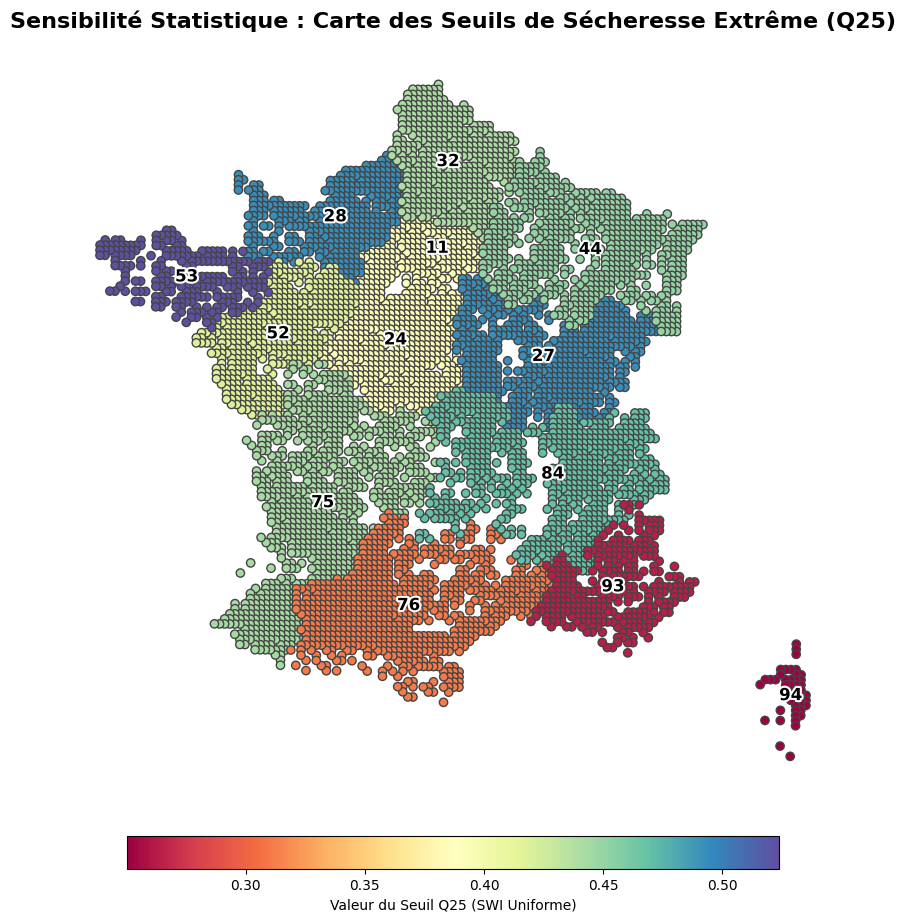

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
import geopandas as gpd

# 1. Calcul du seuil Q25 par région pour l'ensemble de l'année
# (On agrège ici par région pour une lecture claire à l'échelle nationale)
stats_q25 = df_model.groupby('code_insee_de_la_region')['SEUIL_Q25'].mean().reset_index()

# 2. Préparation du fond de carte régional
gdf_regions = gdf_final[['code_insee_de_la_region', 'geometry']].dissolve(by='code_insee_de_la_region').reset_index()
gdf_map_q25 = gdf_regions.merge(stats_q25, on='code_insee_de_la_region')

# 3. Création de la figure
fig, ax = plt.subplots(figsize=(14, 12))

# Tracé de la carte
# Palette Spectral_r : les zones où le seuil est bas (sec) sont en rouge/orange
gdf_map_q25.plot(
    column='SEUIL_Q25', 
    cmap='Spectral', 
    legend=True,
    edgecolor='#444444',
    linewidth=1,
    ax=ax,
    legend_kwds={'label': "Valeur du Seuil Q25 (SWI Uniforme)", 'orientation': "horizontal", 'shrink': 0.6, 'pad': 0.05}
)

# 4. Ajout des étiquettes de régions
for idx, row in gdf_map_q25.iterrows():
    point = row.geometry.representative_point()
    ax.annotate(
        text=row['code_insee_de_la_region'],
        xy=(point.x, point.y),
        ha='center', va='center',
        fontsize=12, fontweight='bold',
        path_effects=[patheffects.withStroke(linewidth=3, foreground='white')]
    )

plt.title("Sensibilité Statistique : Carte des Seuils de Sécheresse Extrême (Q25)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.show()

2. Définition stricte par le 5e percentile

In [16]:
# 1. Calcul du seuil Q5 (5ème percentile) par commune et trimestre
thresholds_q5 = df_drought.groupby(['code_insee_de_la_region', 'TRIMESTRE'])['SWI_UNIF_MENS'].quantile(0.05).reset_index()
thresholds_q5.rename(columns={'SWI_UNIF_MENS': 'SEUIL_Q5'}, inplace=True)

# 2. Fusion avec la base de données
df_drought = df_drought.merge(thresholds_q5, on=['code_insee_de_la_region', 'TRIMESTRE'], how='left')

# 3. Marquage de la Sécheresse Très Extrême
# 1 = Événement rare (5% les plus secs), 0 = Reste du temps
df_drought['IS_VERY_EXTREME_DROUGHT'] = (df_drought['SWI_UNIF_MENS'] < df_drought['SEUIL_Q5']).astype(int)

print(f"Fréquence des événements 'Très Extrêmes' : {df_drought['IS_VERY_EXTREME_DROUGHT'].mean():.2%}")

Fréquence des événements 'Très Extrêmes' : 4.92%


In [17]:
# 1. Calcul des rangs par commune et par trimestre sur l'historique
# 'ascending=True' : les valeurs les plus basses (plus sèches) auront les rangs 1, 2...
df_drought['RANK'] = df_drought.groupby(['code_insee_de_la_region', 'TRIMESTRE'])['SWI_UNIF_MENS'].rank(ascending=True, method='min')

# 2. Application de la règle officielle
# 1 si le rang est 1 ou 2 (soit les 2 années les plus sèches sur 50 ans), 0 sinon
df_drought['IS_OFFICIAL_DROUGHT'] = (df_drought['RANK'] <= 2).astype(int)

# 3. Vérification de la rareté de l'événement
stats_catnat = df_drought['IS_OFFICIAL_DROUGHT'].value_counts(normalize=True)
print(f"Probabilité d'éligibilité CatNat : {stats_catnat[1]:.2%}")

Probabilité d'éligibilité CatNat : 0.05%


In [21]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Définition des prédicteurs
features = ['SPI1_MENS', 'SPI3_MENS', 'SPI6_MENS', 'SPI12_MENS', 'NIVEAU', 'TRIMESTRE']
X = df_drought[features].astype(float)
y = df_drought['IS_OFFICIAL_DROUGHT']

# Split avec stratification (pour conserver la proportion de 1 et 0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Entraînement du modèle avec ajustement des poids (scale_pos_weight) 
# pour compenser la rareté des événements CatNat
clf_official = LGBMClassifier(
    n_estimators=500,
    scale_pos_weight=10, # Donne plus d'importance aux "1" (sécheresses rares)
    objective='binary',
    random_state=42
)

clf_official.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 155, number of negative: 296245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001322 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1029
[LightGBM] [Info] Number of data points in the train set: 296400, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000523 -> initscore=-7.555517
[LightGBM] [Info] Start training from score -7.555517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


Prédiction 2025